# A - gurobi start en license environment (STEP2)

In [1]:
!pip install gurobipy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 26.8 MB/s eta 0:00:00


In [2]:
import networkx as nx
import gurobipy as gp
from gurobipy import *

In [3]:
# Create environment with WLS license
e = gp.Env(empty=True)
e.setParam('WLSACCESSID', '5f70bf63-9610-412d-8ca1-551e7e052c61')
e.setParam('WLSSECRET', '190b5abe-a47c-4738-b218-bb7821931920')
e.setParam('LICENSEID', 887511)
#e.setParam('OutputFlag', 0)
e.start()

# Create the model within the Gurobi environment
#model = gp.Model(env=e)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 887511
Academic license - for non-commercial use only - registered to 482621nt@student.eur.nl


<gurobipy.Env, Parameter changes: WLSAccessID=(user-defined), WLSSecret=(user-defined), LicenseID=887511>

In [4]:
import numpy as np

In [5]:
import tensorflow as tf

In [6]:
import random

# A - gurobi solver and Xtrain en Ytrain with own data 

In [ ]:
varY_list = []
varY2_list = []
lengte = []
werk = 100
ranlist = []
ran = []

# for i in range(werk):
    #Let's say I will have 100 nodes and the connection probability is 0.4
n = 30
# p = 0.2
# piet = np.arange(0,1, (1/werk))
# pietje = piet.tolist()
for p in range(0,werk,1):
    # G = nx.barabasi_albert_graph(n,(random.randint(0, n)))
    #G = nx.barabasi_albert_graph(n,10)
    G= nx.erdos_renyi_graph(n,(p/(werk)))
    #G= nx.erdos_renyi_graph(n,((p+(1*werk))/(werk*5)))
    #G = nx.watts_strogatz_graph(n,10,(p/(werk*10)))
    Gr = nx.to_numpy_array(G)
    
    ranlist.append(Gr)
    ran.append(list(ranlist))
    randy = np.asarray(ran[p])
    xtrain = randy 

    # print(randy.shape)
    G_new = nx.from_numpy_array(randy[p])
    m = gp.Model('chrom_num', env =e)
    
    # get maximum number of variables necessary
    k = max(dict(nx.degree(G_new)).values()) + 1
    K= range(k)
#################################################################################################################################
    # create k binary variables, y_0 ... y_{k-1} to indicate whether color k is used
    y = []
    for j in range(k):
      y.append(m.addVar(vtype=gp.GRB.BINARY, name='y_%d' % j, obj=1))

    # create n * k binary variables, x_{l,j} that is 1 if node l is colored with j
    x = []
    for l in range(n):
      x.append([])
      for j in range(k):
        x[-1].append(m.addVar(vtype=gp.GRB.BINARY, name='x_%d_%d' % (l, j), obj=0))


    # label_dict = {}
    # label_num = 0
    # for j in range(n):
    #       if (y[j] == 0):
    #           y[j] = 0  # so if value of out put is zero, than varY remains zero
              
    #       else:
    #           if (varY[j]) in label_dict:
    #              varY[j] = label_dict[varY[j]]
    #           else:
    #              label_dict[varY[j]] = label_num #if the value is already in the label_dict, no new label/color has to be made
    #              varY[j] = label_num
    #              label_num = label_num + 1  


    # objective function is minimize colors used --> sum of y_0 ... y_{k-1}
    m.setObjective(gp.quicksum(y[j] for j in K), gp.GRB.MINIMIZE)
    m.update()

    # add constraint -- each node gets exactly one color (sum of colors used is 1)
    for u in range(n):
        m.addConstr(gp.quicksum(x[u]) == 1, name='NC_%d')

    # add constraint -- keep track of colors used (y_j is set high if any time j is used)
    for l in range(n):
        for j in range(k):
            m.addConstr(x[u][j] <= y[j], name='SH_%d_%d')

    # add constraint -- adjacent nodes have different colors
    for u in range(n):
        for v in G[u]:
            if v > u:
                for j in range(k):
                    m.addConstr(x[u][j] + x[v][j] <= 1, name='ADJ_%d_%d_COL_%d')

    # add constraint -- adjacent nodes have different colors
    for u in range(n):
        for v in G[u]:
            if v > u:
                for j in range(k):
                    m.addConstr(x[u][j] + x[v][j] <= y[j], name='ADJ_%d_%d_COL_%d')
#################################################################################################################################
    # update model, solve, return the chromatic number
    
    m.update()
    #m.setParam('MIPGap', 0.15)
    m.setParam('TimeLimit', 5)
    m.optimize()
    #chrom_num = []
    
    chrom_num = m.objVal
    chrom_num_int = int(chrom_num)
    print('-------')
    print('-------')
    print("chromatic number of this graph is ", m.objVal)


    varZ= m.getAttr("x")
    varX = m.getVars()  
    lengte.append(len(y))
    vargurY = varZ[0:lengte[p]]
    vargurX = varZ[lengte[p]:] 

    varY3_reshape = np.reshape(vargurX,(n,lengte[p]))
    varY3_backup = varY3_reshape
    # print('backupVarY3', varY3_backup)
    for ti in range(chrom_num_int):
      varY3_reshape[:,ti] = varY3_reshape[:,ti]*(ti+1)
      varY3_reshape_new = np.extract(varY3_reshape!=0, varY3_reshape)
      # ertg = np.pad(varY3_reshape_new, (0, 100 - len(varY3_reshape_new)%100), 'constant')  #toegevoegde functie en dan ook nu regel ertg beneden toegegevoed 
      varY3_reshape_list = varY3_reshape_new.tolist()
      # varY3_reshape_list = ertg.tolist()
    # print('de gereshapte versie', varY3_reshape)
    # print('alleen de kleuren', varY3_reshape_new)
    # y2_train.shape
    varY_list.append(varY3_reshape_list)
    varY2_list.append(list(varY_list))
    varY3 = np.asarray(varY2_list[p])
    y2_train = tf.keras.utils.to_categorical(y = varY3, num_classes=n+1)

    m.reset()

print('shape van de reshape is',varY3.shape)
print(varY3)
print('n is ', n)
print('loop is ', werk)
print(y2_train.shape)



-------
-------
chromatic number of this graph is  1.0
-------
-------
chromatic number of this graph is  2.0
-------
-------
chromatic number of this graph is  2.0
-------
-------
chromatic number of this graph is  2.0
-------
-------
chromatic number of this graph is  3.0
-------
-------
chromatic number of this graph is  3.0
-------
-------
chromatic number of this graph is  2.0
-------
-------
chromatic number of this graph is  3.0
-------
-------
chromatic number of this graph is  3.0
-------
-------
chromatic number of this graph is  3.0
-------
-------
chromatic number of this graph is  3.0
-------
-------
chromatic number of this graph is  3.0
-------
-------
chromatic number of this graph is  3.0
-------
-------
chromatic number of this graph is  4.0
-------
-------
chromatic number of this graph is  4.0
-------
-------
chromatic number of this graph is  4.0
-------
-------
chromatic number of this graph is  4.0
-------
-------
chromatic number of this graph is  4.0
-------
--

In [ ]:
ertg = np.pad(varY3_reshape_new,100)
ertg = np.pad(varY3_reshape_new, (0, 100 - len(varY3_reshape_new)%100), 'constant')
ertg.shape

(100,)

In [ ]:
np.save('testset/xtest_100_erdos.npy', xtrain)
np.save('testset/ytest_100_erdos.npy', y2_train)
xtest_100_erdos = np.load('testset/xtest_100_erdos.npy')
ytest_100_erdos = np.load('testset/ytest_100_erdos.npy')

# A -  Train data maken en samenvoegen (STEP3)

## erdos trainingsdata (12802, 30, 30)

In [13]:
xtrain_1000_n30_erdos_p34_1 = np.load('trainset/xtrain_2000_n30_erdos_p34_1.npy')
xtrain_1000_n30_erdos_p34_2 = np.delete(xtrain_1000_n30_erdos_p34_1, len(xtrain_1000_n30_erdos_p34_1)-1,0)
xtrain_1000_n30_erdos_p34_2.shape


(1802, 30, 30)

In [14]:
xtrain_1000_n30_erdos_p01_1 = np.load('trainset/xtrain_2000_n30_erdos_p01_1.npy')
ytrain_1000_n30_erdos_p01_1 = np.load('trainset/ytrain_2000_n30_erdos_p01_1.npy')

xtrain_1000_n30_erdos_p12_1 = np.load('trainset/xtrain_2000_n30_erdos_p12_1.npy')
ytrain_1000_n30_erdos_p12_1 = np.load('trainset/ytrain_2000_n30_erdos_p12_1.npy')

xtrain_1000_n30_erdos_p23_1 = np.load('trainset/xtrain_2000_n30_erdos_p23_1.npy')
ytrain_1000_n30_erdos_p23_1 = np.load('trainset/ytrain_2000_n30_erdos_p23_1.npy')

xtrain_1000_n30_erdos_p34_1 = np.load('trainset/xtrain_2000_n30_erdos_p34_1.npy')
ytrain_1000_n30_erdos_p34_1 = np.load('trainset/ytrain_2000_n30_erdos_p34_1.npy')

xtrain_1000_n30_erdos_p45_1 = np.load('trainset/xtrain_2000_n30_erdos_p45_1.npy')
ytrain_1000_n30_erdos_p45_1 = np.load('trainset/ytrain_2000_n30_erdos_p45_1.npy')

In [15]:
xtrain_1000_n30_erdos_p34_2 = np.delete(xtrain_1000_n30_erdos_p34_1, len(xtrain_1000_n30_erdos_p34_1)-1,0)
xtrain_1000_n30_erdos_p34_2.shape

(1802, 30, 30)

In [16]:
x_erdos_combined = np.concatenate((xtrain_1000_n30_erdos_p01_1,
                                   xtrain_1000_n30_erdos_p12_1,
                                   xtrain_1000_n30_erdos_p23_1,
                                   xtrain_1000_n30_erdos_p34_2, ##
                                   xtrain_1000_n30_erdos_p45_1), axis = 0)

y_erdos_combined = np.concatenate((ytrain_1000_n30_erdos_p01_1,
                                   ytrain_1000_n30_erdos_p12_1,
                                   ytrain_1000_n30_erdos_p23_1,
                                   ytrain_1000_n30_erdos_p34_1,
                                   ytrain_1000_n30_erdos_p45_1), axis = 0)

print(x_erdos_combined.shape)
print(y_erdos_combined.shape)



(12802, 30, 30)
(12802, 30, 31)


## watts (16864, 30, 30) met varierende k = 8 (want k/n-1 = p if B =1 en lijk op erdos)  en B = 0 en 1 uniform

In [17]:
xtrain_1000_n30_watts_p01_1 = np.load('trainset/xtrain_5000_n30_watts_p01_1.npy')
ytrain_1000_n30_watts_p01_1 = np.load('trainset/ytrain_5000_n30_watts_p01_1.npy')

xtrain_1000_n30_watts_p12_1 = np.load('trainset/xtrain_5000_n30_watts_p12_1.npy')
ytrain_1000_n30_watts_p12_1 = np.load('trainset/ytrain_5000_n30_watts_p12_1.npy')

xtrain_1000_n30_watts_p23_1 = np.load('trainset/xtrain_5000_n30_watts_p23_1.npy')
ytrain_1000_n30_watts_p23_1 = np.load('trainset/ytrain_5000_n30_watts_p23_1.npy')

xtrain_1000_n30_watts_p34_1 = np.load('trainset/xtrain_5000_n30_watts_p34_1.npy')
ytrain_1000_n30_watts_p34_1 = np.load('trainset/ytrain_5000_n30_watts_p34_1.npy')

xtrain_1000_n30_watts_p45_1 = np.load('trainset/xtrain_5000_n30_watts_p45_1.npy')
ytrain_1000_n30_watts_p45_1 = np.load('trainset/ytrain_5000_n30_watts_p45_1.npy')

In [18]:
xtrain_1000_n30_watts_p01_2 = np.delete(xtrain_1000_n30_watts_p01_1, len(xtrain_1000_n30_watts_p01_1)-1,0)
xtrain_1000_n30_watts_p01_2.shape
xtrain_1000_n30_watts_p23_2 = np.delete(xtrain_1000_n30_watts_p23_1, len(xtrain_1000_n30_watts_p23_1)-1,0)
xtrain_1000_n30_watts_p23_2.shape
xtrain_1000_n30_watts_p34_2 = np.delete(xtrain_1000_n30_watts_p34_1, len(xtrain_1000_n30_watts_p34_1)-1,0)
xtrain_1000_n30_watts_p34_2.shape
xtrain_1000_n30_watts_p45_2 = np.delete(xtrain_1000_n30_watts_p45_1, len(xtrain_1000_n30_watts_p45_1)-1,0)
xtrain_1000_n30_watts_p45_2.shape

(2471, 30, 30)

In [19]:
x_watts_combined = np.concatenate((xtrain_1000_n30_watts_p01_2,#
                                   xtrain_1000_n30_watts_p12_1,
                                   xtrain_1000_n30_watts_p23_2,#
                                   xtrain_1000_n30_watts_p34_2,#
                                   xtrain_1000_n30_watts_p45_2), axis = 0)#

y_watts_combined = np.concatenate((ytrain_1000_n30_watts_p01_1,#
                                   ytrain_1000_n30_watts_p12_1,
                                   ytrain_1000_n30_watts_p23_1,#
                                  ytrain_1000_n30_watts_p34_1,#
                                   ytrain_1000_n30_watts_p45_1), axis = 0)#

print(x_watts_combined.shape)
print(y_watts_combined.shape)

(16864, 30, 30)
(16864, 30, 31)


## barbasi graph (22696, 30, 30) 5000 graphs met variatie van k 0 en n uniform minimum van 1. let op k = n/2 is grootte struggle

In [20]:
xtrain_1000_n30_basi_p01_1 = np.load('trainset/xtrain_5000_n30_basi_p01_1.npy')
ytrain_1000_n30_basi_p01_1 = np.load('trainset/ytrain_5000_n30_basi_p01_1.npy')

xtrain_1000_n30_basi_p12_1 = np.load('trainset/xtrain_5000_n30_basi_p12_1.npy')
ytrain_1000_n30_basi_p12_1 = np.load('trainset/ytrain_5000_n30_basi_p12_1.npy')

xtrain_1000_n30_basi_p23_1 = np.load('trainset/xtrain_5000_n30_basi_p23_1.npy')
ytrain_1000_n30_basi_p23_1 = np.load('trainset/ytrain_5000_n30_basi_p23_1.npy')

xtrain_1000_n30_basi_p34_1 = np.load('trainset/xtrain_5000_n30_basi_p34_1.npy')
ytrain_1000_n30_basi_p34_1 = np.load('trainset/ytrain_5000_n30_basi_p34_1.npy')

xtrain_1000_n30_basi_p45_1 = np.load('trainset/xtrain_5000_n30_basi_p45_1.npy')
ytrain_1000_n30_basi_p45_1 = np.load('trainset/ytrain_5000_n30_basi_p45_1.npy')

In [21]:
xtrain_1000_n30_basi_p12_2 = np.delete(xtrain_1000_n30_basi_p12_1, len(xtrain_1000_n30_basi_p12_1)-1,0)
xtrain_1000_n30_basi_p12_2.shape


(2696, 30, 30)

In [22]:
x_basi_combined = np.concatenate((xtrain_1000_n30_basi_p01_1,
                                   xtrain_1000_n30_basi_p12_2, #
                                   xtrain_1000_n30_basi_p23_1,
                                   xtrain_1000_n30_basi_p34_1,
                                   xtrain_1000_n30_basi_p45_1), axis = 0)

y_basi_combined = np.concatenate((ytrain_1000_n30_basi_p01_1,
                                  ytrain_1000_n30_basi_p12_1, # 
                                   ytrain_1000_n30_basi_p23_1,
                                   ytrain_1000_n30_basi_p34_1,
                                   ytrain_1000_n30_basi_p45_1), axis = 0)

print(x_basi_combined.shape)
print(y_basi_combined.shape)

(22696, 30, 30)
(22696, 30, 31)


# A - totaal traindata (52362, 30, 30) (STEP4)

In [23]:
x_train_15000 = np.concatenate((x_erdos_combined, x_watts_combined, x_basi_combined), axis = 0 )
y_train_15000 = np.concatenate((y_erdos_combined, y_watts_combined, y_basi_combined), axis = 0 )

np.save('trainset/x_train_totaalall.npy',x_train_15000)
np.save('trainset/y_train_totaalall.npy',y_train_15000)



In [24]:
x_train_15000 = np.load('trainset/x_train_totaalall.npy')
y_train_15000 = np.load('trainset/y_train_totaalall.npy')

print(x_train_15000.shape)
print(y_train_15000.shape)

(52362, 30, 30)
(52362, 30, 31)


# Testdata 1000 watzz graphs, (1000,100,100) VERKEERD AANTAL NODES

In [ ]:
np.save('xtrain_1000_wattz.npy', xtrain)
np.save('ytrain_1000_wattz.npy', y2_train)
x_train_1000_wattz = np.load('xtrain_1000_wattz.npy')
y_train_1000_wattz = np.load('ytrain_1000_wattz.npy')

In [ ]:
print(x_train_1000_wattz.shape)
print(y_train_1000_wattz.shape)
print(x_train_1000.shape)
print(y_train_1000.shape)

(1000, 100, 100)
(1000, 100, 101)


In [ ]:
x_combined = np.concatenate((x_train_1000, x_train_1000_wattz), axis = 0)
y_combined = np.concatenate((y_train_1000, y_train_1000_wattz), axis = 0)
print(x_combined.shape)
print(y_combined.shape)

(2000, 100, 100)
(2000, 100, 101)


# Testdata 2000 wtss graphs (2000,30,30) 

In [ ]:
x_train_1000_watts = np.load('trainset/juiste 30/xtrain_1000_n30_watts_p01_1.npy')
y_train_1000_watts = np.load('trainset/juiste 30/ytrain_1000_n30_watts_p01_1.npy')
x_train_1000_basi = np.load('trainset/juiste 30/xtrain_1000_n30_basi_p23_1.npy')
y_train_1000_basi = np.load('trainset/juiste 30/ytrain_1000_n30_basi_p23_1.npy')
print(x_train_1000_watts.shape)
print(y_train_1000_watts.shape)
print(x_train_1000_basi.shape)
print(y_train_1000_basi.shape)
#xtest_10_wattz = np.load('trainset/xtrain_1000_n30_watts_p12_1.npy')
#ytest_10_wattz = np.load('trainset/ytrain_1000_n30_watts_p12_1.npy')

FileNotFoundError: ignored

In [ ]:
y_basi_combined.shape

# B - GAN  import start (STEP1) 

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
%cd /content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/


/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan


In [9]:
pip install igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.5 MB/s eta 0:00:00


In [10]:
pip install powerlaw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import training
from training import Trainer
import utils
import pdb
import torch
import matplotlib.pyplot as plt
import numpy as np
import igraph

%matplotlib inline
import pandas as pd
import scipy
from utils import graph_from_scores
import networkx as nx

In [12]:
import scipy.io
from scipy.sparse import coo_matrix, isspmatrix


# Synthetic test data maken 

In [ ]:
# create test graph
n_test = 30
p_test = 0.95
m_test = 27 ###########################################################################################################
q_test = 12
#G_test = nx.erdos_renyi_graph(n_test, p_test)
#G_test = nx.barabasi_albert_graph(n_test,m_test)
# G_test = nx.barabasi_albert_graph(n_test,m_test)
G_test = nx.watts_strogatz_graph(n_test,q_test,p_test)


graph = nx.to_numpy_array(G_test)
#graph = np.pad(graph, (35,35) , mode= 'edge')
graph[graph!=0] = 1.0
graph_nx = nx.from_numpy_array(graph)
graph_sparse = scipy.sparse.csr_matrix(graph)

n_edges = graph.sum()

nx.draw(graph_nx, with_labels = True)
graph_sparse

<30x30 sparse matrix of type '<class 'numpy.float64'>'
	with 360 stored elements in Compressed Sparse Row format>

In [ ]:
trainer = Trainer(graph_sparse, len(graph), max_iterations=2000, rw_len=8, batch_size=128, H_gen=40, H_disc=30, H_inp=128, z_dim=16, lr=0.0003,
                  n_critic=3, gp_weight=10.0, betas=(.5, .9), l2_penalty_disc=5e-5, l2_penalty_gen=1e-7, temp_start=5.0,  
                  val_share=0.2, test_share=0.1, seed=20, set_ops=False) #max iterationn = 20000
trainer.train(create_graph_every=100, plot_graph_every=200, num_samples_graph=50000, stopping_criterion='val')

trans_mat = trainer.create_transition_matrix(50000)
graph_synthetic = []
werk = 100 ########################################################################################################################################
for i in range(werk):
    graph_sampled = graph_from_scores(trans_mat, n_edges)
    graph_synthetic.append(graph_sampled)
    graph_nx_sampled = nx.from_numpy_array(graph_sampled)
    nx.draw(graph_nx_sampled, node_size=25, alpha=0.5)
    plt.show()

for r, graph_sampled in enumerate(graph_synthetic):
    graph_sampled = scipy.sparse.csc_matrix(graph_sampled)
    path = 'synth/graph_syn_watts''_n' +str(n_test)+'_k12'+'_p9505'+'_'+str(r)+ '.npz' #######################################################################################
    scipy.sparse.save_npz(path, graph_sampled)

**** Using VAL criterion for early stopping with max patience of: 10****


KeyboardInterrupt: ignored

In [33]:
t2 = np.array(graph_synthetic)
print(t2.shape)
varY_list_test = []
varY2_list_test = []
werk = 100   ####################################################################################################################
ranlist = []
ran = []
n = 30 
lengte = []

# for i in range(werk):
    #Let's say I will have 100 nodes and the connection probability is 0.4
n = 30
# p = 0.2

for p in range(0,werk,1):
  # G = nx.barabasi_albert_graph(n,(random.randint(0, n)))
  #G = nx.barabasi_albert_graph(n,10)
  #G= nx.erdos_renyi_graph(n,((p+(1*werk))/(werk*5)))
  #G = nx.watts_strogatz_graph(n,10,(p/(werk*10)))
  # Gr = nx.to_numpy_array(G)
  # G= nx.erdos_renyi_graph(n,(p/(werk)))
  # ranlist.append(Gr)
  # ran.append(list(ranlist))
  # randy = np.asarray(ran[p])
  # xtrain = randy 

  # print(randy.shape)
  test_B = nx.from_numpy_array(t2[p])
  m = gp.Model('chrom_num', env =e)

  # get maximum number of variables necessary
  k = max(dict(nx.degree(test_B)).values()) + 1
  K= range(k)
  #################################################################################################################################
  # create k binary variables, y_0 ... y_{k-1} to indicate whether color k is used
  y = []
  for j in range(k):
    y.append(m.addVar(vtype=gp.GRB.BINARY, name='y_%d' % j, obj=1))

  # create n * k binary variables, x_{l,j} that is 1 if node l is colored with j
  x = []
  for l in range(n):
    x.append([])
    for j in range(k):
      x[-1].append(m.addVar(vtype=gp.GRB.BINARY, name='x_%d_%d' % (l, j), obj=0))


  # objective function is minimize colors used --> sum of y_0 ... y_{k-1}
  m.setObjective(gp.quicksum(y[j] for j in K), gp.GRB.MINIMIZE)
  m.update()

  # add constraint -- each node gets exactly one color (sum of colors used is 1)
  for u in range(n):
      m.addConstr(gp.quicksum(x[u]) == 1, name='NC_%d')

  # add constraint -- keep track of colors used (y_j is set high if any time j is used)
  for l in range(n):
      for j in range(k):
          m.addConstr(x[u][j] <= y[j], name='SH_%d_%d')

  # add constraint -- adjacent nodes have different colors
  for u in range(n):
      for v in test_B[u]:
          if v > u:
              for j in range(k):
                  m.addConstr(x[u][j] + x[v][j] <= 1, name='ADJ_%d_%d_COL_%d')

  # add constraint -- adjacent nodes have different colors
  for u in range(n):
      for v in test_B[u]:
          if v > u:
              for j in range(k):
                  m.addConstr(x[u][j] + x[v][j] <= y[j], name='ADJ_%d_%d_COL_%d')
  #################################################################################################################################
  # update model, solve, return the chromatic number

  m.update()
  m.setParam('MIPGap', 0.01)
  m.setParam('TimeLimit',10)
  m.optimize()
  #chrom_num = []

  chrom_num_test = m.objVal
  chrom_num_int_test = int(chrom_num_test)
  print('-------')
  print('-------')
  print("chromatic number of this graph is ", m.objVal)


  varZ_test= m.getAttr("x")
  varX_test = m.getVars()  
  lengte.append(len(y))
  vargurY_test = varZ_test[0:lengte[p]]
  vargurX_test = varZ_test[lengte[p]:] 

  varY3_reshape_test = np.reshape(vargurX_test,(n,lengte[p]))
  varY3_backup_test = varY3_reshape_test
  # print('backupVarY3', varY3_backup)
  for ti in range(chrom_num_int_test):
    varY3_reshape_test[:,ti] = varY3_reshape_test[:,ti]*(ti+1)
    varY3_reshape_new_test = np.extract(varY3_reshape_test !=0, varY3_reshape_test)
    varY3_reshape_list_test = varY3_reshape_new_test.tolist()
  # print('de gereshapte versie', varY3_reshape)
  # print('alleen de kleuren', varY3_reshape_new)
  # y2_train.shape
  varY_list_test.append(varY3_reshape_list_test)
  varY2_list_test.append(list(varY_list_test))
  varY3_test = np.asarray(varY2_list_test[p])
  y2_train_test = tf.keras.utils.to_categorical(y =(varY3_test), num_classes=n+1)

  m.reset()

  print('shape van de reshape is',varY3_test.shape)
  # print(varY3_test)
  print('n is ', n)
  # print('loop is ', werk)
  print(y2_train_test.shape)

x_test = t2
y_test = y2_train_test
print(x_test.shape)
print(y_test.shape)
np.save('synthetic_set/X_syn_watts_n30_k12_p9505', x_test) ###########################################################################################################
np.save('synthetic_set/Y_syn_watts_n30_k12_p9505', y_test) ###########################################################################################################

y_test56 = np.array_split(y_test,werk)
y_test89 = np.array(y_test56)
x_test56 = np.array_split(x_test,werk)
x_test89 = np.array(x_test56)
print(x_test89.shape)
print(y_test89.shape)

np.save('colorcorrection/X_split_syn_watts_n30_k12_p9505.npy', x_test89) ###########################################################################################################
np.save('colorcorrection/Y_split_syn_watts_n30_k12_p9505.npy', y_test89) ###########################################################################################################


(5, 30, 30)
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 10
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to 482621nt@student.eur.nl
Optimize a model with 7050 rows, 558 columns and 17820 nonzeros
Model fingerprint: 0xb8612480
Variable types: 0 continuous, 558 integer (558 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 17.0000000
Presolve removed 3780 rows and 0 columns
Presolve time: 0.06s
Presolved: 3270 rows, 558 columns, 10260 nonzeros
Variable types: 0 continuous, 558 integer (558 binary)

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objectiv

IndexError: ignored

In [ ]:
# y_test56 = np.array_split(y_test,werk)
# y_test89 = np.array(y_test56)
# print(y_test89.shape)

# x_test56 = np.array_split(x_test,werk)
# x_test89 = np.array(x_test56)
# print(x_test89.shape)
# np.save('colorcorrection/X_syn_basi_n30_m3.npy', x_test89)
# np.save('colorcorrection/Y_syn_basi_n30_m3.npy', y_test89)

# Synthetic data erdos (990 graphs)

In [ ]:
# n =30 en p = 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9 elk 110 

e9X = np.load('synthetic_set/X_syn_erdos_n30_p0.9.npy')
e8X = np.load('synthetic_set/X_syn_erdos_n30_p0.8.npy')
e7X = np.load('synthetic_set/X_syn_erdos_n30_p0.7.npy')
e6X = np.load('synthetic_set/X_syn_erdos_n30_p0.6.npy')
e5X = np.load('synthetic_set/X_syn_erdos_n30_p0.5.npy')
e4X = np.load('synthetic_set/X_syn_erdos_n30_p0.4.npy')
e3X = np.load('synthetic_set/X_syn_erdos_n30_p0.3.npy')
e2X = np.load('synthetic_set/X_syn_erdos_n30_p0.2.npy')
e1X = np.load('synthetic_set/X_syn_erdos_n30_p0.1.npy')



ptotaalerdosX = np.concatenate((e9X,e8X,e7X,e6X,e5X,e4X,e3X,e2X,e1X), axis = 0 )
print(ptotaalerdosX.shape) #(990,30,30)
np.save('synthetic_set/Xtotalsynt_erdos_n30',ptotaalerdosX)

e9Y = np.load('synthetic_set/Y_syn_erdos_n30_p0.9.npy')
e8Y = np.load('synthetic_set/Y_syn_erdos_n30_p0.8.npy')
e7Y = np.load('synthetic_set/Y_syn_erdos_n30_p0.7.npy')
e6Y = np.load('synthetic_set/Y_syn_erdos_n30_p0.6.npy')
e5Y = np.load('synthetic_set/Y_syn_erdos_n30_p0.5.npy')
e4Y = np.load('synthetic_set/Y_syn_erdos_n30_p0.4.npy')
e3Y = np.load('synthetic_set/Y_syn_erdos_n30_p0.3.npy')
e2Y = np.load('synthetic_set/Y_syn_erdos_n30_p0.2.npy')
e1Y = np.load('synthetic_set/Y_syn_erdos_n30_p0.1.npy')


ptotaalerdosY = np.concatenate((e9Y,e8Y,e7Y,e6Y,e5Y,e4Y,e3Y,e2Y,e1Y), axis = 0 )
print(ptotaalerdosY.shape) #(990,30,31)
np.save('synthetic_set/Ytotalsynt_erdos_n30',ptotaalerdosY)


(990, 30, 30)
(990, 30, 31)


In [ ]:
n_test = 30
p_test = 0.05
G_test = nx.erdos_renyi_graph(n_test, p_test)


graph = nx.to_numpy_array(G_test)
graph[graph!=0] = 1.0


In [ ]:
utils.compute_graph_statistics(graph)

Values less than or equal to 0 in data. Throwing out 0 or negative values


{'d_max': 4.0,
 'd_min': 0.0,
 'd': 1.2666666666666666,
 'LCC': 18,
 'wedge_count': 23.0,
 'claw_count': 6.0,
 'triangle_count': 1,
 'square_count': 0,
 'power_law_exp': 2.7844177270584485,
 'gini': 0.4017543859649122,
 'rel_edge_distr_entropy': 0.8575941487430297,
 'assortativity': 0.16399999999999929,
 'clustering_coefficient': 0.5,
 'n_components': 12,
 'cpl': 4.538961038961039}

In [ ]:
utils.compute_graph_statistics(e1X[50])


{'d_max': 7.0,
 'd_min': 1.0,
 'd': 3.066666666666667,
 'LCC': 30,
 'wedge_count': 119.0,
 'claw_count': 93.0,
 'triangle_count': 8,
 'square_count': 0,
 'power_law_exp': 1.9662481084483363,
 'gini': 0.14855072463768115,
 'rel_edge_distr_entropy': 0.9760549265138483,
 'assortativity': -0.07595852423438608,
 'clustering_coefficient': 0.25806451612903225,
 'n_components': 1,
 'cpl': 3.4919540229885055}

# Synthetic test data watts (1000 graphs)

In [ ]:
# k =12 en p = 0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95 elk 100

p0515X = np.load('synthetic_set/X_syn_watts_n30_k12_p0515.npy')
p1525X = np.load('synthetic_set/X_syn_watts_n30_k12_p1525.npy')
p2535X = np.load('synthetic_set/X_syn_watts_n30_k12_p2535.npy')
p3545X = np.load('synthetic_set/X_syn_watts_n30_k12_p3545.npy')
p4555X = np.load('synthetic_set/X_syn_watts_n30_k12_p4555.npy')
p5565X = np.load('synthetic_set/X_syn_watts_n30_k12_p5565.npy')
p6575X = np.load('synthetic_set/X_syn_watts_n30_k12_p6575.npy')
p7585X = np.load('synthetic_set/X_syn_watts_n30_k12_p7585.npy')
p8595X = np.load('synthetic_set/X_syn_watts_n30_k12_p8595.npy')
p9505X = np.load('synthetic_set/X_syn_watts_n30_k12_p9505.npy')

ptotaalwattsX = np.concatenate((p0515X,p1525X,p2535X,p3545X,p4555X,p5565X,p6575X,p7585X,p8595X,p9505X), axis = 0)
print(ptotaalwattsX.shape) #(1000,30,30)
np.save('synthetic_set/Xtotalsynt_watss_n30', ptotaalwattsX)


p0515Y = np.load('synthetic_set/Y_syn_watts_n30_k12_p0515.npy')
p1525Y = np.load('synthetic_set/Y_syn_watts_n30_k12_p1525.npy')
p2535Y = np.load('synthetic_set/Y_syn_watts_n30_k12_p2535.npy')
p3545Y = np.load('synthetic_set/Y_syn_watts_n30_k12_p3545.npy')
p4555Y = np.load('synthetic_set/Y_syn_watts_n30_k12_p4555.npy')
p5565Y = np.load('synthetic_set/Y_syn_watts_n30_k12_p5565.npy')
p6575Y = np.load('synthetic_set/Y_syn_watts_n30_k12_p6575.npy')
p7585Y = np.load('synthetic_set/Y_syn_watts_n30_k12_p7585.npy')
p8595Y = np.load('synthetic_set/Y_syn_watts_n30_k12_p8595.npy')
p9505Y = np.load('synthetic_set/Y_syn_watts_n30_k12_p9505.npy')

ptotaalwattsY = np.concatenate((p0515Y,p1525Y,p2535Y,p3545Y,p4555Y,p5565Y,p6575Y,p7585Y,p8595Y,p9505Y), axis = 0)
print(ptotaalwattsY.shape) #(1000,30,31)
np.save('synthetic_set/Ytotalsynt_watss_n30', ptotaalwattsY)

(1000, 30, 30)
(1000, 30, 31)


In [ ]:
n_test = 30
q_test = 12
p_test = 0.95
G_test = nx.watts_strogatz_graph(n_test,q_test,p_test)

graph = nx.to_numpy_array(G_test)
graph[graph!=0] = 1.0


In [ ]:
utils.compute_graph_statistics(graph)

{'d_max': 17.0,
 'd_min': 7.0,
 'd': 12.0,
 'LCC': 30,
 'wedge_count': 2065.0,
 'claw_count': 7541.0,
 'triangle_count': 277,
 'square_count': 103,
 'power_law_exp': 2.9287458706752214,
 'gini': 0.04481481481481464,
 'rel_edge_distr_entropy': 0.9941441804382238,
 'assortativity': -0.03822063858810056,
 'clustering_coefficient': 0.11019758652698582,
 'n_components': 1,
 'cpl': 1.5885057471264368}

In [ ]:
utils.compute_graph_statistics(ptotaalwattsX[950])

{'d_max': 22.0,
 'd_min': 7.0,
 'd': 12.0,
 'LCC': 30,
 'wedge_count': 2120.0,
 'claw_count': 8325.0,
 'triangle_count': 325,
 'square_count': 225,
 'power_law_exp': 2.9616274593795646,
 'gini': 0.0653703703703703,
 'rel_edge_distr_entropy': 0.9911042774868534,
 'assortativity': -0.12176639665534798,
 'clustering_coefficient': 0.11711711711711711,
 'n_components': 1,
 'cpl': 1.5862068965517242}

# Synthetic test data basi (1015 graphs)

In [ ]:
# n =30 en m = 2,3,4,5,6,7,8,9,(5x12),(5x17),(5x22),(6x27), elke is 35


m2529X = np.load('synthetic_set/X_syn_basi_n30_m2529.npy')
m2024X = np.load('synthetic_set/X_syn_basi_n30_m2024.npy')
m1519X = np.load('synthetic_set/X_syn_basi_n30_m1519.npy')
m1014X = np.load('synthetic_set/X_syn_basi_n30_m1014.npy')
m9X = np.load('synthetic_set/X_syn_basi_n30_m9.npy')
m8X = np.load('synthetic_set/X_syn_basi_n30_m8.npy')
m7X = np.load('synthetic_set/X_syn_basi_n30_m7.npy')
m6X = np.load('synthetic_set/X_syn_basi_n30_m6.npy')
m5X = np.load('synthetic_set/X_syn_basi_n30_m5.npy')
m4X = np.load('synthetic_set/X_syn_basi_n30_m4.npy')
m3X = np.load('synthetic_set/X_syn_basi_n30_m3.npy')
m1X = np.load('synthetic_set/X_syn_basi_n30_m1.npy')

mtotaalbasiX = np.concatenate((m1X,m3X,m4X,m5X,m6X,m7X,m8X,m9X,m1014X,m1519X,m2024X,m2529X), axis= 0)
# mtotaalbasiX = np.concatenate((m2529X,m2024X,m1519X,m1014X,m9X,m8X,m7X,m6X,m5X,m4X,m3X,m1X), axis = 0 )
print(mtotaalbasiX.shape) #(1015,30,30)
# np.save('synthetic_set/Xtotalsynt_basi_n30',mtotaalbasiX)


m2529Y = np.load('synthetic_set/Y_syn_basi_n30_m2529.npy')
m2024Y = np.load('synthetic_set/Y_syn_basi_n30_m2024.npy')
m1519Y = np.load('synthetic_set/Y_syn_basi_n30_m1519.npy')
m1014Y = np.load('synthetic_set/Y_syn_basi_n30_m1014.npy')
m9Y = np.load('synthetic_set/Y_syn_basi_n30_m9.npy')
m8Y = np.load('synthetic_set/Y_syn_basi_n30_m8.npy')
m7Y = np.load('synthetic_set/Y_syn_basi_n30_m7.npy')
m6Y = np.load('synthetic_set/Y_syn_basi_n30_m6.npy')
m5Y = np.load('synthetic_set/Y_syn_basi_n30_m5.npy')
m4Y = np.load('synthetic_set/Y_syn_basi_n30_m4.npy')
m3Y = np.load('synthetic_set/Y_syn_basi_n30_m3.npy')
m1Y = np.load('synthetic_set/Y_syn_basi_n30_m1.npy')

mtotaalbasiY = np.concatenate((m2529Y,m2024Y,m1519Y,m1014Y,m9Y,m8Y,m7Y,m6Y,m5Y,m4Y,m3Y,m1Y), axis = 0 )
print(mtotaalbasiY.shape) #(1015,30,31)
# np.save('synthetic_set/Ytotalsynt_basi_n30',mtotaalbasiY)

(1015, 30, 30)
(1015, 30, 31)


In [ ]:
m2529X.shape  #35 helegetallen en 175 en 2529 = 210

(210, 30, 30)

In [ ]:
n_test = 30
p_test = 27
G_test = nx.barabasi_albert_graph(n_test,p_test)

graph = nx.to_numpy_array(G_test)
graph[graph!=0] = 1.0


In [ ]:
utils.compute_graph_statistics(graph)

{'d_max': 29.0,
 'd_min': 1.0,
 'd': 5.4,
 'LCC': 30,
 'wedge_count': 1211.0,
 'claw_count': 9880.0,
 'triangle_count': 77,
 'square_count': 25,
 'power_law_exp': 1.7862914467799327,
 'gini': 0.368312757201646,
 'rel_edge_distr_entropy': 0.8356978656916724,
 'assortativity': -0.9269088830987687,
 'clustering_coefficient': 0.023380566801619432,
 'n_components': 1,
 'cpl': 1.813793103448276}

In [ ]:
utils.compute_graph_statistics(mtotaalbasiX[910])

{'d_max': 29.0,
 'd_min': 2.0,
 'd': 5.4,
 'LCC': 30,
 'wedge_count': 1187.0,
 'claw_count': 9533.0,
 'triangle_count': 77,
 'square_count': 26,
 'power_law_exp': 2.6872331338640674,
 'gini': 0.37572016460905333,
 'rel_edge_distr_entropy': 0.8397782013966932,
 'assortativity': -0.9036711278403738,
 'clustering_coefficient': 0.024231616490087066,
 'n_components': 1,
 'cpl': 1.813793103448276}

# SYNTHETIC TOTAAL DATASET (3005,30,30) (STEP5)

In [25]:
x_basi = np.load('synthetic_set/Xtotalsynt_basi_n30.npy')
x_watts = np.load('synthetic_set/Xtotalsynt_watss_n30.npy')
x_erdos = np.load('synthetic_set/Xtotalsynt_erdos_n30.npy')

y_basi = np.load('synthetic_set/Ytotalsynt_basi_n30.npy')
y_watts = np.load('synthetic_set/Ytotalsynt_watss_n30.npy')
y_erdos = np.load('synthetic_set/Ytotalsynt_erdos_n30.npy')

x_synth_totaal = np.concatenate((x_basi,x_watts,x_erdos), axis = 0 )
y_synth_totaal = np.concatenate((y_basi,y_watts,y_erdos), axis = 0 )

np.save('synthetic_set/x_synth_totaal', x_synth_totaal)
np.save('synthetic_set/y_synth_totaal', y_synth_totaal)
print(x_synth_totaal.shape)
print(y_synth_totaal.shape)

(3005, 30, 30)
(3005, 30, 31)


In [ ]:
stats_basi_s = x_basi[1]
stats_basi_s2 = x_basi[200]
stats_basi_o = x_basi_combined[1]
stats_basi_o2 = x_basi_combined[200]
stats_erdos_s = x_erdos[1]
stats_erdos_s2 = x_erdos[200]
stats_erdos_o = x_erdos_combined[1]
stats_erdos_o2 = x_erdos_combined[200]
stats_watts_s = x_watts[1]
stats_watts_s2 = x_watts[200]
stats_watts_o = x_watts_combined[1]
stats_watts_o2 = x_watts_combined[200]


In [ ]:
utils.compute_graph_statistics(stats_basi_s)
utils.compute_graph_statistics(stats_basi_s2)
utils.compute_graph_statistics(stats_basi_o)
utils.compute_graph_statistics(stats_basi_o2)

utils.compute_graph_statistics(stats_erdos_s)
utils.compute_graph_statistics(stats_erdos_s2)
#utils.compute_graph_statistics(stats_erdos_o)
utils.compute_graph_statistics(stats_erdos_o2)

utils.compute_graph_statistics(stats_watts_s)
utils.compute_graph_statistics(stats_watts_s2)
utils.compute_graph_statistics(stats_watts_o)
utils.compute_graph_statistics(stats_watts_o2)

AttributeError: ignored

In [ ]:
utils.compute_graph_statistics(stats2)

In [ ]:
utils.edge_overlap(stats1, stats3)

In [ ]:
utils.compute_graph_statistics(stats3)

In [ ]:
utils.compute_graph_statistics(stats4)

# load dat for final experiment 

In [26]:
#
xtest_Mutag_30 = np.load('exp5/xtest_Mutag_30.npy', allow_pickle= True)
ytest_Mutag_30 = np.load('exp5/ytest_Mutag_30.npy')

#
xtest_Enzymes_130 = np.load('exp5/xtest_Enzymes_130.npy', allow_pickle= True)
ytest_Enzymes_130 = np.load('exp5/ytest_Enzymes_130.npy')

#
xtest_Karateclub_40 = np.load('exp5/xtest_Karateclub_40.npy', allow_pickle= True)
ytest_Karateclub_40 = np.load('exp5/ytest_Karateclub_40.npy')

#
xtest_CSL_50 = np.load('exp5/xtest_CSL_50.npy', allow_pickle= True)
ytest_CSL_50 = np.load('exp5/ytest_CSL_50.npy')

#
xtest_QM7b_30 = np.load('exp5/xtest_QM7b_30.npy', allow_pickle= True)
ytest_QM7b_30 = np.load('exp5/ytest_QM7b_30.npy')
xtest_QM7b_30 = xtest_QM7b_30[0:5406]


#
xtest_QM9_30 = np.load('exp5/xtest_QM9_30.npy', allow_pickle= True)
ytest_QM9_30 = np.load('exp5/ytest_QM9_30.npy')

# xtest_MD17_30 = np.load('exp5/xtest_MD17_30.npy', allow_pickle= True)
# ytest_MD17_30 = np.load('exp5/ytest_MD17_30.npy')

#
xtest_Aids_30 = np.load('exp5/xtest_Aids_30.npy', allow_pickle= True)
ytest_Aids_30 = np.load('exp5/ytest_Aids_30.npy')

#
xtest_Linux_30 = np.load('exp5/xtest_Linux_30.npy', allow_pickle= True)
ytest_Linux_30 = np.load('exp5/ytest_Linux_30.npy')

#
xtest_Alkane_30 = np.load('exp5/xtest_Alkane_30.npy', allow_pickle= True)
ytest_Alkane_30 = np.load('exp5/ytest_Alkane_30.npy')

#
xtest_DAS_30 = np.load('exp5/xtest_DAS_30.npy', allow_pickle= True)
ytest_DAS_30 = np.load('exp5/ytest_DAS_30.npy')

# B - GAN (test) data input

In [ ]:
graph = scipy.io.mmread('inf-USAir97.mtx')
#graph = nx.from_scipy_sparse_array(graph) 
graph = nx.from_scipy_sparse_matrix(graph) #extra geaddd
graph = nx.to_numpy_array(graph)
graph[graph!=0] = 1.0
graph_nx = nx.from_numpy_array(graph)
graph_sparse = scipy.sparse.csr_matrix(graph)
n_edges = graph.sum()

In [ ]:
nx.draw(graph_nx, node_size=25, alpha=0.5)


NameError: ignored

In [ ]:
# create test graph
n_test = 30
p_test = 0.6
m_test = 12
q_test = 8
# G_test = nx.erdos_renyi_graph(n_test, p_test)
G_test = nx.barabasi_albert_graph(n_test,m_test)
# G_test = nx.watts_strogatz_graph(n_test,q_test,p_test)


graph = nx.to_numpy_array(G_test)
#graph = np.pad(graph, (35,35) , mode= 'edge')
graph[graph!=0] = 1.0
graph_nx = nx.from_numpy_array(graph)
graph_sparse = scipy.sparse.csr_matrix(graph)

n_edges = graph.sum()

nx.draw(graph_nx, with_labels = True)

In [ ]:
graph_sparse

<30x30 sparse matrix of type '<class 'numpy.float64'>'
	with 432 stored elements in Compressed Sparse Row format>

# B - GAN optimizer 

sparse synthetic miller

In [ ]:
trainer = Trainer(graph_sparse, len(graph), max_iterations=20000, rw_len=6, batch_size=128, H_gen=40, H_disc=30, H_inp=128, z_dim=16, lr=0.0003,
                  n_critic=3, gp_weight=10.0, betas=(.5, .9), l2_penalty_disc=5e-5, l2_penalty_gen=1e-7, temp_start=5.0,  
                  val_share=0.2, test_share=0.1, seed=20, set_ops=False) #max iterationn = 20000


**** Using VAL criterion for early stopping with max patience of: 10****
iteration: 1      critic: 3.487118      gen -0.021976
iteration: 11      critic: 0.008656      gen -0.078259
iteration: 21      critic: -0.010273      gen -0.073969
iteration: 31      critic: -0.084350      gen -0.100439
iteration: 41      critic: -0.134918      gen -0.063607
iteration: 51      critic: -0.131161      gen -0.050469
iteration: 61      critic: -0.120979      gen -0.016758
iteration: 71      critic: -0.147641      gen -0.026590
iteration: 81      critic: -0.119926      gen -0.068591
iteration: 91      critic: -0.127576      gen -0.039174
1
11
21
31
41
roc: 0.7001   avp: 0.7492   eo: 0.5278
Took 0.5580405275026957 minutes so far..
iteration: 101      critic: -0.111343      gen -0.052825
iteration: 111      critic: -0.078315      gen -0.044371
iteration: 121      critic: -0.110794      gen -0.082435
iteration: 131      critic: -0.039855      gen -0.054928
iteration: 141      critic: -0.030617      gen -

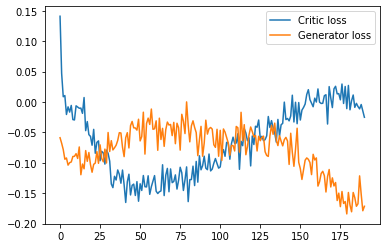

iteration: 201      critic: -0.011203      gen -0.158616
iteration: 211      critic: -0.041080      gen -0.198652
iteration: 221      critic: -0.029093      gen -0.200648
iteration: 231      critic: -0.047190      gen -0.202397
iteration: 241      critic: -0.048990      gen -0.217068
iteration: 251      critic: -0.031459      gen -0.199590
iteration: 261      critic: -0.026695      gen -0.170881
iteration: 271      critic: -0.043325      gen -0.120902
iteration: 281      critic: -0.054111      gen -0.104784
iteration: 291      critic: -0.062945      gen -0.065756
1
11
21
31
41
roc: 0.6871   avp: 0.6947   eo: 0.5509
Took 1.5739736596743266 minutes so far..
iteration: 301      critic: -0.053471      gen -0.083311
iteration: 311      critic: -0.072310      gen -0.088801
iteration: 321      critic: -0.063893      gen -0.110764
iteration: 331      critic: -0.072739      gen -0.086368
iteration: 341      critic: -0.098884      gen -0.115758
iteration: 351      critic: -0.084896      gen -0.1

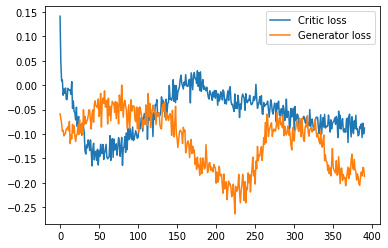

iteration: 401      critic: -0.080932      gen -0.188147
iteration: 411      critic: -0.094471      gen -0.197546
iteration: 421      critic: -0.093672      gen -0.219126
iteration: 431      critic: -0.094854      gen -0.262398
iteration: 441      critic: -0.120223      gen -0.217162
iteration: 451      critic: -0.108293      gen -0.208751
iteration: 461      critic: -0.122794      gen -0.199280
iteration: 471      critic: -0.130303      gen -0.214125
iteration: 481      critic: -0.131081      gen -0.208321
iteration: 491      critic: -0.140313      gen -0.212788
1
11
21
31
41
roc: 0.6990   avp: 0.7375   eo: 0.6065
Took 2.6326409498850505 minutes so far..
iteration: 501      critic: -0.140208      gen -0.253020
iteration: 511      critic: -0.149581      gen -0.236823
iteration: 521      critic: -0.154205      gen -0.198840
iteration: 531      critic: -0.141365      gen -0.231680
iteration: 541      critic: -0.149300      gen -0.226049
iteration: 551      critic: -0.144292      gen -0.2

iteration: 601      critic: -0.151663      gen -0.214709
iteration: 611      critic: -0.147219      gen -0.225818
iteration: 621      critic: -0.168569      gen -0.237148
iteration: 631      critic: -0.160115      gen -0.218884
iteration: 641      critic: -0.164116      gen -0.187582
iteration: 651      critic: -0.146970      gen -0.227521
iteration: 661      critic: -0.155567      gen -0.218653
iteration: 671      critic: -0.159166      gen -0.194183
iteration: 681      critic: -0.171073      gen -0.187569
iteration: 691      critic: -0.157341      gen -0.219224
1
11
21
31
41
roc: 0.7280   avp: 0.7226   eo: 0.5787
Took 3.60649094581604 minutes so far..
iteration: 701      critic: -0.141326      gen -0.237088
iteration: 711      critic: -0.178328      gen -0.187476
iteration: 721      critic: -0.164730      gen -0.225632
iteration: 731      critic: -0.168618      gen -0.182155
iteration: 741      critic: -0.160527      gen -0.161041
iteration: 751      critic: -0.143766      gen -0.203

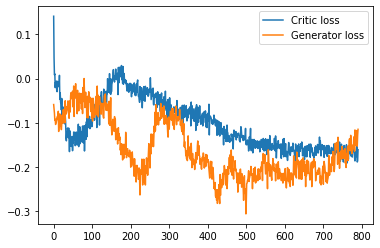

iteration: 801      critic: -0.163811      gen -0.107551
iteration: 811      critic: -0.174903      gen -0.108725
iteration: 821      critic: -0.168289      gen -0.146136
iteration: 831      critic: -0.163367      gen -0.109624
iteration: 841      critic: -0.169109      gen -0.154283
iteration: 851      critic: -0.166407      gen -0.108224
iteration: 861      critic: -0.177805      gen -0.172271
iteration: 871      critic: -0.158682      gen -0.133606
iteration: 881      critic: -0.169412      gen -0.113428
iteration: 891      critic: -0.181132      gen -0.104917
1
11
21
31
41
roc: 0.6950   avp: 0.6942   eo: 0.6111
Took 4.583782915274302 minutes so far..
iteration: 901      critic: -0.182223      gen -0.129271
iteration: 911      critic: -0.170814      gen -0.096869
iteration: 921      critic: -0.175412      gen -0.083907
iteration: 931      critic: -0.148126      gen -0.112832
iteration: 941      critic: -0.154371      gen -0.084644
iteration: 951      critic: -0.165251      gen -0.09

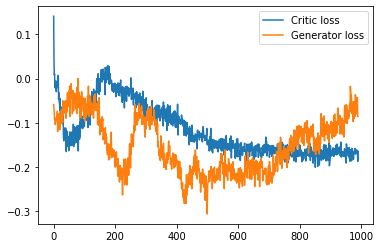

iteration: 1001      critic: -0.135179      gen -0.093532
iteration: 1011      critic: -0.160413      gen -0.043356
iteration: 1021      critic: -0.155846      gen -0.073045
iteration: 1031      critic: -0.154956      gen -0.044738
iteration: 1041      critic: -0.148615      gen -0.026816
iteration: 1051      critic: -0.184465      gen -0.045288
iteration: 1061      critic: -0.152891      gen -0.047606
iteration: 1071      critic: -0.160072      gen -0.014936
iteration: 1081      critic: -0.169081      gen -0.015715
iteration: 1091      critic: -0.167936      gen -0.064740
1
11
21
31
41
roc: 0.6725   avp: 0.6608   eo: 0.6620
Took 5.553755128383637 minutes so far..
iteration: 1101      critic: -0.152957      gen -0.050015
iteration: 1111      critic: -0.153675      gen 0.005032
iteration: 1121      critic: -0.123120      gen -0.032374
iteration: 1131      critic: -0.148485      gen -0.012596
iteration: 1141      critic: -0.166936      gen 0.026049
iteration: 1151      critic: -0.143787 

In [ ]:
trainer.train(create_graph_every=100, plot_graph_every=200, num_samples_graph=50000, stopping_criterion='val')

original cora from miller dataset

In [ ]:
# trainer = Trainer(_A_obs,_N, max_iterations=50, rw_len=16, batch_size=128, H_gen=40, H_disc=30, H_inp=128, z_dim=16, lr=0.0003,
                  # n_critic=3, gp_weight=10.0, betas=(.5, .9), l2_penalty_disc=5e-5, l2_penalty_gen=1e-7, temp_start=5.0,  
                  # val_share=0.1, test_share=0.05, seed=0)
#trainer = Trainer(_A_obs, _N, max_iterations=40000, rw_len=16, batch_size=128, H_gen=40, H_disc=30, H_inp=128, z_dim=16, lr=0.0003,
                  #n_critic=3, gp_weight=10.0, betas=(.5, .9), l2_penalty_disc=5e-5, l2_penalty_gen=1e-7, temp_start=5.0,  
                  #val_share=0.1, test_share=0.05, seed=0)

1
11
21
31
41


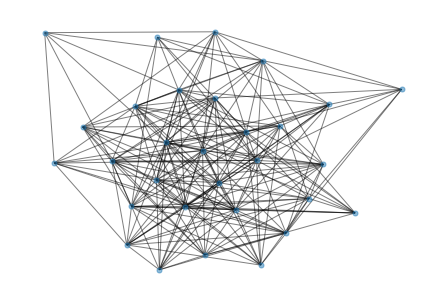

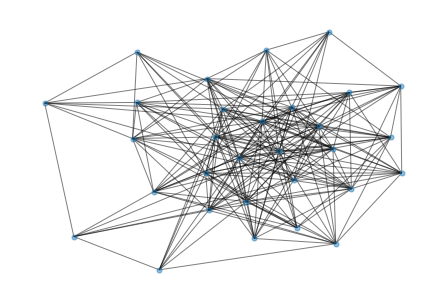

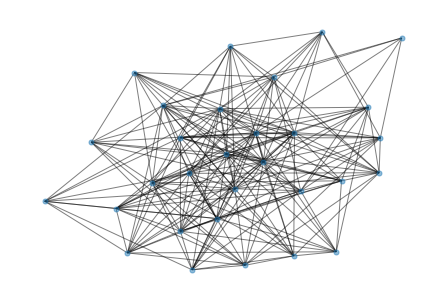

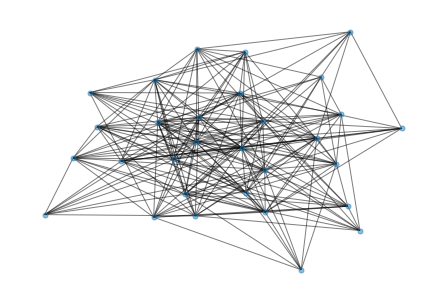

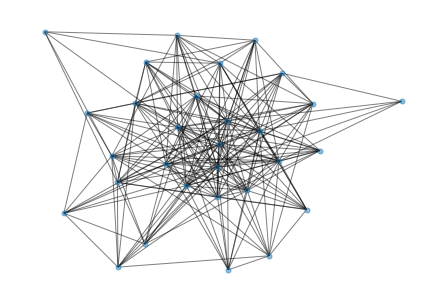

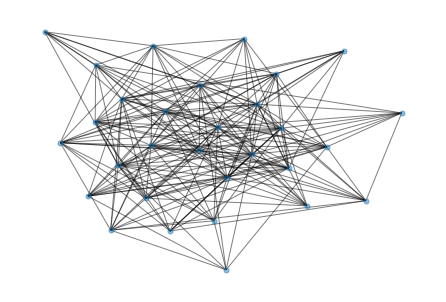

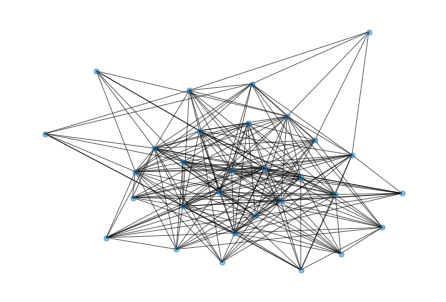

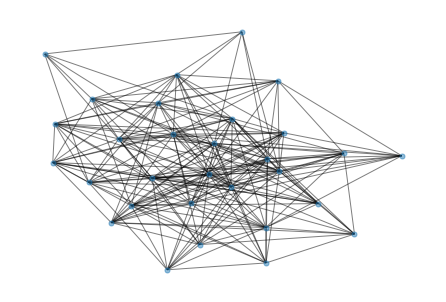

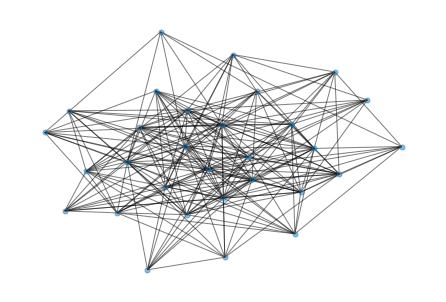

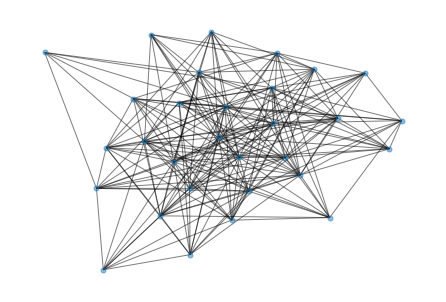

In [ ]:
trans_mat = trainer.create_transition_matrix(50000)
graph_synthetic = []
for i in range(10):
    graph_sampled = graph_from_scores(trans_mat, n_edges)
    graph_synthetic.append(graph_sampled)
    graph_nx_sampled = nx.from_numpy_array(graph_sampled)
    nx.draw(graph_nx_sampled, node_size=25, alpha=0.5)
    plt.show()

In [ ]:

for i, graph_sampled in enumerate(graph_synthetic):
    graph_sampled = scipy.sparse.csc_matrix(graph_sampled)
    path = 'graph_eigendata_test(n=30)_basi_30_12'+str(i) + '.npz'
    scipy.sparse.save_npz(path, graph_sampled)

In [ ]:
graph_sampled = scipy.sparse.csr_matrix.toarray(graph_sampled)

In [ ]:
t2 = np.array(graph_synthetic)
print(t2.shape)

(10, 30, 30)


In [ ]:
fake_graph = np.reshape(graph_sampled, (1,) + (graph_sampled.shape))
x2_pred = fake_graph
fake_graph.shape

(1, 30, 30)

In [ ]:
test_B = nx.from_numpy_array(graph_sampled)
#test_B = nx.from_scipy_sparse_matrix(graph_sampled)
ERG_1 = nx.greedy_color(test_B, strategy='largest_first', interchange=False)
print('number of edges for the coloring greedy:',test_B.number_of_edges())
print('number of nodes for the coloring greedy:', test_B.number_of_nodes())

number of edges for the coloring greedy: 166
number of nodes for the coloring greedy: 30


# B - de gurobi model voor gan synthetic

In [ ]:

test_B = graph_nx
n=30
fake_graph = np.reshape(graph, (1,) + (graph.shape))

In [161]:
varY_list_test = []
varY2_list_test = []
werk = 5
ranlist = []
ran = []
n = 30 
lengte = []

# for i in range(werk):
    #Let's say I will have 100 nodes and the connection probability is 0.4
n = 30
# p = 0.2
t2 = reshapert
for p in range(5):
  # G = nx.barabasi_albert_graph(n,(random.randint(0, n)))
  #G = nx.barabasi_albert_graph(n,10)
  #G= nx.erdos_renyi_graph(n,((p+(1*werk))/(werk*5)))
  #G = nx.watts_strogatz_graph(n,10,(p/(werk*10)))
  # Gr = nx.to_numpy_array(G)
  # G= nx.erdos_renyi_graph(n,(p/(werk)))
  # ranlist.append(Gr)
  # ran.append(list(ranlist))
  # randy = np.asarray(ran[p])
  # xtrain = randy 

  # print(randy.shape)
  test_B = nx.from_numpy_array(t2[p])
  m = gp.Model('chrom_num', env =e)

  # get maximum number of variables necessary
  k = max(dict(nx.degree(test_B)).values()) + 1
  K= range(k)
  #################################################################################################################################
  # create k binary variables, y_0 ... y_{k-1} to indicate whether color k is used
  y = []
  for j in range(k):
    y.append(m.addVar(vtype=gp.GRB.BINARY, name='y_%d' % j, obj=1))

  # create n * k binary variables, x_{l,j} that is 1 if node l is colored with j
  x = []
  for l in range(n):
    x.append([])
    for j in range(k):
      x[-1].append(m.addVar(vtype=gp.GRB.BINARY, name='x_%d_%d' % (l, j), obj=0))


  # objective function is minimize colors used --> sum of y_0 ... y_{k-1}
  m.setObjective(gp.quicksum(y[j] for j in K), gp.GRB.MINIMIZE)
  m.update()

  # add constraint -- each node gets exactly one color (sum of colors used is 1)
  for u in range(n):
      m.addConstr(gp.quicksum(x[u]) == 1, name='NC_%d')

  # add constraint -- keep track of colors used (y_j is set high if any time j is used)
  for l in range(n):
      for j in range(k):
          m.addConstr(x[u][j] <= y[j], name='SH_%d_%d')

  # add constraint -- adjacent nodes have different colors
  for u in range(n):
      for v in test_B[u]:
          if v > u:
              for j in range(k):
                  m.addConstr(x[u][j] + x[v][j] <= 1, name='ADJ_%d_%d_COL_%d')

  # add constraint -- adjacent nodes have different colors
  for u in range(n):
      for v in test_B[u]:
          if v > u:
              for j in range(k):
                  m.addConstr(x[u][j] + x[v][j] <= y[j], name='ADJ_%d_%d_COL_%d')
  #################################################################################################################################
  # update model, solve, return the chromatic number

  m.update()
  m.setParam('MIPGap', 0.01)
  m.setParam('TimeLimit', 80)
  m.optimize()
  #chrom_num = []

  chrom_num_test = m.objVal
  chrom_num_int_test = int(chrom_num_test)
  print('-------')
  print('-------')
  print("chromatic number of this graph is ", m.objVal)


  varZ_test= m.getAttr("x")
  varX_test = m.getVars()  
  lengte.append(len(y))
  vargurY_test = varZ_test[0:lengte[p]]
  vargurX_test = varZ_test[lengte[p]:] 

  varY3_reshape_test = np.reshape(vargurX_test,(n,lengte[p]))
  varY3_backup_test = varY3_reshape_test
  # print('backupVarY3', varY3_backup)
  for ti in range(chrom_num_int_test):
    varY3_reshape_test[:,ti] = varY3_reshape_test[:,ti]*(ti+1)
    varY3_reshape_new_test = np.extract(varY3_reshape_test !=0, varY3_reshape_test)
    varY3_reshape_list_test = varY3_reshape_new_test.tolist()
  # print('de gereshapte versie', varY3_reshape)
  # print('alleen de kleuren', varY3_reshape_new)
  # y2_train.shape
  varY_list_test.append(varY3_reshape_list_test)
  varY2_list_test.append(list(varY_list_test))
  varY3_test = np.asarray(varY2_list_test[p])
#   y2_train_test = tf.keras.utils.to_categorical(y = varY3_test, num_classes=n+1)

  m.reset()

#   print('shape van de reshape is',varY3_test.shape)
#   print(varY3_test)
#   print('n is ', n)
#   # print('loop is ', werk)
#   print(y2_train_test.shape)

# x_test = t2
# y_test = y2_train_test



Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 80
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to 482621nt@student.eur.nl
Optimize a model with 7050 rows, 558 columns and 17820 nonzeros
Model fingerprint: 0xb8612480
Variable types: 0 continuous, 558 integer (558 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 17.0000000
Presolve removed 3780 rows and 0 columns
Presolve time: 0.07s
Presolved: 3270 rows, 558 columns, 10260 nonzeros
Variable types: 0 continuous, 558 integer (558 binary)

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 2.000000e+

In [160]:
np.array(varY3_reshape_list_test)

array([1., 2., 2., 2., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 2., 1., 2.,
       1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1.])

In [158]:
varY3_test

array([[ 1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  2.,  3.,  1.,  1.,
         1.,  1.,  1.,  4.,  3.,  2.,  4.,  5.,  1.,  1.,  1.,  2.,  3.,
         5.,  1.,  4.,  5.],
       [ 1.,  2.,  4.,  3.,  1.,  4.,  1.,  5.,  1.,  2.,  6.,  4.,  9.,
         7.,  1.,  7.,  3.,  8.,  8.,  6.,  1.,  5.,  3.,  9., 10., 10.,
         6.,  1., 10.,  2.],
       [ 1.,  2.,  3.,  4.,  5.,  4.,  6.,  1.,  6.,  6.,  3.,  9.,  7.,
         8.,  1.,  4.,  8.,  7.,  2.,  9.,  5.,  8.,  9.,  2.,  5.,  1.,
         3.,  2.,  4.,  5.],
       [ 1.,  2.,  3.,  4.,  1.,  4.,  1.,  2.,  7.,  2.,  1.,  1.,  3.,
         5.,  1.,  5.,  2.,  4.,  1.,  1.,  5.,  3.,  5.,  3.,  1.,  1.,
         1.,  3.,  7.,  1.],
       [ 1.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,
         1.,  2.,  1.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         2.,  1.,  1.,  1.]])

In [ ]:
print(x_test.shape)
print(y_test.shape)

NameError: ignored

In [ ]:
np.save('testset/xtest_5_faken30.npy', fake_graph)
np.save('testset/ytest_5_faken30.npy', y2_train_test)
x_test =  np.load('testset/xtest_5_faken30.npy')
y_test = np.load('testset/ytest_5_faken30.npy')

In [ ]:
x_test =  np.load('testset/xtest_5_faken30.npy')


#### Y_pred (niet meer) 

In [ ]:
y2_pred = ERG_1.values()
print(y2_pred)
print(len(y2_pred))
##########controle
max_key = max(ERG_1, key=ERG_1.get)
print(max_key)
all_values = ERG_1.values()
max_value = max(all_values)
print(max_value)

dict_values([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 1, 0, 1, 1, 2, 0, 1, 0, 1, 1, 2, 2, 1, 0, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1])
100
58
2


# C - LSTM start packages 

In [ ]:
! pip install spektral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 KB 12.0 MB/s eta 0:00:00


In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from __future__ import division
import keras
import csv
import tensorflow as tf
from numpy.random import seed
from keras import backend as K
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
seed(1)
tf.random.set_seed(2)
import sklearn.preprocessing as preprocessing
from random import randint
from numpy import array
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding, Input, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from spektral.layers import GCNConv, GlobalSumPool
from spektral.data.loaders import DisjointLoader
from spektral.data import Dataset
from spektral.utils import normalized_laplacian
#from spektral.layers.ops import sp_matrix_to_sp_tensor
from spektral.utils import sparse
np.set_printoptions(threshold=sys.maxsize)

# C LSTM network definen en trainen van het network 

In [ ]:
def plot_loss_accuracy(history, validation):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    if ('val_categorical_accuracy' in history.history.keys()):
        plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy exp5 ('+str(bits1)+','+str(bits2)+','+str(bits3)+')'',n='+str(n)+',n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+validation)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('exp5/exp5_Accuracy_('+str(bits1)+','+str(bits2)+','+str(bits3)+')''_n='+str(n)+',n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+',training=all', format='eps'+validation)
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    if ('val_loss' in history.history.keys()):
        plt.plot(history.history['val_loss'])
    plt.title('model loss exp5 ('+str(bits1)+','+str(bits2)+','+str(bits3)+')'',n='+str(n)+',n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+validation)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('exp5/Loss_exp5('+str(bits1)+','+str(bits2)+','+str(bits3)+')''_n='+str(n)+',n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+',training=all', format='eps'+validation)
    plt.show() #synth3005

### 3 LSTMs (Original-1024,1024,1024)

In [35]:
n = 30

In [ ]:
#Use this Input format for direct input to LSTM
seqsize = 30
seq_inputs = layers.Input(shape=(seqsize,30,), dtype='float32')
bits1 = 512 #1024
bits2 = 512 #1024
bits3 = 512 #1024
n_epoch= 20 #10
n_batch= 64  #64

# #2 layer LSTM 
# encoder = layers.LSTM(bits1, return_sequences=True, name="lstm_1")(seq_inputs) #1024
# decoder = layers.LSTM(bits2, return_sequences=True, name="lstm_2")(encoder)  #1024
# decoderoutputs = layers.TimeDistributed(layers.Dense(31,activation="softmax"))(decoder)

# #1layer LSTM
# encoder = layers.LSTM(bits1, return_sequences=True, name="lstm_1")(seq_inputs) #1024
# decoderoutputs = layers.TimeDistributed(layers.Dense(31,activation="softmax"))(encoder)

# # 3 layer lstm
encoder = layers.LSTM(bits1, return_sequences=True, name="lstm_1")(seq_inputs) #1024
encoder = layers.LSTM(bits2, return_sequences=True, name="lstm_2")(encoder)  #1024
decoder = layers.LSTM(bits3, return_sequences=True, name="lstm_3")(encoder)  #1024
decoderoutputs = layers.TimeDistributed(layers.Dense(31,activation="softmax"))(decoder)

# 3layer biLSTM
# encoder = layers.Bidirectional(layers.LSTM(bits1, return_sequences=True, name="Bilstm_1"))(seq_inputs)
# encoder = layers.Bidirectional(layers.LSTM(bits2, return_sequences=True, name="Bilstm_2"))(encoder)
# encoder = layers.Bidirectional(layers.LSTM(bits3, return_sequences=True, name="Bilstm_3"))(encoder)
# decoderoutputs = layers.TimeDistributed(layers.Dense(31, activation="softmax"))(encoder)

# # 3 layer GRU
# encoder = layers.GRU(bits1, return_sequences=True, name="GRU_1")(seq_inputs) #1024
# encoder = layers.GRU(bits2, return_sequences=True, name="GRU_2")(encoder)  #1024
# decoder = layers.GRU(bits3, return_sequences=True, name="GRU_3")(encoder)  #1024
# decoderoutputs = layers.TimeDistributed(layers.Dense(31,activation="softmax"))(decoder)


model = tf.keras.Model(inputs=seq_inputs, outputs=decoderoutputs)



# model.compile(optimizer="adam", loss="mean_absolute_percentage_error", metrics=['mean_absolute_percentage_error'])
# model.compile(optimizer="adam", loss="mean_squared_error", metrics=['MeanAbsoluteError'])
# model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_crossentropy'])
print (model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 30, 30)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 512)           1112064   
                                                                 
 lstm_2 (LSTM)               (None, 30, 512)           2099200   
                                                                 
 lstm_3 (LSTM)               (None, 30, 512)           2099200   
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 31)           15903     
 tributed)                                                       
                                                                 
Total params: 5,326,367
Trainable params: 5,326,367
Non-trainable params: 0
_________________________________________________

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta = 0.005)
# history1 = model.fit(x_train_15000, y_train_15000, epochs=n_epoch, batch_size=n_batch, verbose=1, shuffle=True,callbacks = [callback] ,validation_data=(xtest_Mutag_30.astype('float32'), ytest_Mutag_30.astype('float32')))
# history2 = model.fit(x_train_15000, y_train_15000, epochs=n_epoch, batch_size=n_batch, verbose=1, shuffle=True,callbacks = [callback] ,validation_data=(xtest_QM7b_30.astype('float32') ,ytest_QM7b_30.astype('float32')))
# history3 = model.fit(x_train_15000, y_train_15000, epochs=n_epoch, batch_size=n_batch, verbose=1, shuffle=True,callbacks = [callback] ,validation_data=(xtest_QM9_30.astype('float32'),ytest_QM9_30.astype('float32')))
# history4 = model.fit(x_train_15000, y_train_15000, epochs=n_epoch, batch_size=n_batch, verbose=1, shuffle=True,callbacks = [callback] ,validation_data=(xtest_Aids_30.astype('float32'), ytest_Aids_30.astype('float32')))
# history5 = model.fit(x_train_15000, y_train_15000, epochs=n_epoch, batch_size=n_batch, verbose=1, shuffle=True,callbacks = [callback] ,validation_data=(xtest_Linux_30.astype('float32'),ytest_Linux_30.astype('float32')))
# history6 = model.fit(x_train_15000, y_train_15000, epochs=n_epoch, batch_size=n_batch, verbose=1, shuffle=True,callbacks = [callback] ,validation_data=(xtest_Alkane_30.astype('float32'),ytest_Alkane_30.astype('float32')))
history7 = model.fit(x_train_15000, y_train_15000, epochs=n_epoch, batch_size=n_batch, verbose=1, shuffle=True,callbacks = [callback] ,validation_data=(xtest_DAS_30,ytest_DAS_30))

#x_synth_totaal
# x_erdos_combined
# x_train_15000

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])


ValueError: ignored

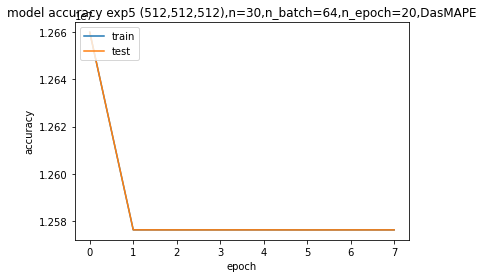

In [ ]:
# plot_loss_accuracy(history1, validation = ',Mutag_30')
# plot_loss_accuracy(history2, validation = ',QM7b')
# plot_loss_accuracy(history3, validation = ',QM9')
# plot_loss_accuracy(history4, validation = ',Aids')
# plot_loss_accuracy(history5, validation = ',Linux')
# plot_loss_accuracy(history6, validation = ',Alkane')
plot_loss_accuracy(history7, validation = ',DasMAPE')

In [ ]:
import json
# Get the dictionary containing each metric and the loss for each epoch
# history_dict1 = history1.history
# history_dict2 = history2.history
# history_dict3 = history3.history
# history_dict4 = history4.history
# history_dict5 = history5.history
# history_dict6 = history6.history
history_dict7 = history7.history
# Save it under the form of a json file
# json.dump(history_dict1, open('/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/LSTM_MODELS/HISTORY_exp5('+str(bits1)+','+str(bits2)+','+str(bits3)+'),n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+'Mutag,training=all''_n='+str(n), 'w'))
# history_dict = json.load(open('/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/LSTM_MODELS/HISTORY_exp5('+str(bits1)+','+str(bits2)+','+str(bits3)+'),n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+'Mutag,training=all''_n='+str(n), 'r'))
# model.save('/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/LSTM_MODELS/exp5('+str(bits1)+','+str(bits2)+','+str(bits3)+')''_n='+str(n)+',n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+'Mutag,training=all')

# json.dump(history_dict2, open('/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/LSTM_MODELS/HISTORY_exp5('+str(bits1)+','+str(bits2)+','+str(bits3)+'),n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+'QM7B,training=all''_n='+str(n), 'w'))
# history_dict = json.load(open('/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/LSTM_MODELS/HISTORY_exp5('+str(bits1)+','+str(bits2)+','+str(bits3)+'),n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+'QM7B,training=all''_n='+str(n), 'r'))
# model.save('/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/LSTM_MODELS/exp5('+str(bits1)+','+str(bits2)+','+str(bits3)+')''_n='+str(n)+',n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+'QM7B,training=all')

# json.dump(history_dict3, open('/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/LSTM_MODELS/HISTORY_exp5('+str(bits1)+','+str(bits2)+','+str(bits3)+'),n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+'QM9,training=all''_n='+str(n), 'w'))
# history_dict = json.load(open('/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/LSTM_MODELS/HISTORY_exp5('+str(bits1)+','+str(bits2)+','+str(bits3)+'),n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+'QM9,training=all''_n='+str(n), 'r'))
# model.save('/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/LSTM_MODELS/exp5('+str(bits1)+','+str(bits2)+','+str(bits3)+')''_n='+str(n)+',n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+'QM9,training=all')

# json.dump(history_dict4, open('/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/LSTM_MODELS/HISTORY_exp5('+str(bits1)+','+str(bits2)+','+str(bits3)+'),n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+'Aids,training=all''_n='+str(n), 'w'))
# history_dict = json.load(open('/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/LSTM_MODELS/HISTORY_exp5('+str(bits1)+','+str(bits2)+','+str(bits3)+'),n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+'Aids,training=all''_n='+str(n), 'r'))
# model.save('/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/LSTM_MODELS/exp5('+str(bits1)+','+str(bits2)+','+str(bits3)+')''_n='+str(n)+',n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+'Aids,training=all')

# json.dump(history_dict5, open('/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/LSTM_MODELS/HISTORY_exp5('+str(bits1)+','+str(bits2)+','+str(bits3)+'),n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+'Linux,training=all''_n='+str(n), 'w'))
# history_dict = json.load(open('/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/LSTM_MODELS/HISTORY_exp5('+str(bits1)+','+str(bits2)+','+str(bits3)+'),n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+'Linux,training=all''_n='+str(n), 'r'))
# model.save('/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/LSTM_MODELS/exp5('+str(bits1)+','+str(bits2)+','+str(bits3)+')''_n='+str(n)+',n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+'Linux,training=all')

# json.dump(history_dict6, open('/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/LSTM_MODELS/HISTORY_exp5('+str(bits1)+','+str(bits2)+','+str(bits3)+'),n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+'Alkane,training=all''_n='+str(n), 'w'))
# history_dict = json.load(open('/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/LSTM_MODELS/HISTORY_exp5('+str(bits1)+','+str(bits2)+','+str(bits3)+'),n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+'Alkane,training=all''_n='+str(n), 'r'))
# model.save('/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/LSTM_MODELS/exp5('+str(bits1)+','+str(bits2)+','+str(bits3)+')''_n='+str(n)+',n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+'Alkane,training=all')

json.dump(history_dict7, open('/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/LSTM_MODELS/HISTORY_exp5('+str(bits1)+','+str(bits2)+','+str(bits3)+'),n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+'Das,training=all''_n='+str(n), 'w'))
history_dict = json.load(open('/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/LSTM_MODELS/HISTORY_exp5('+str(bits1)+','+str(bits2)+','+str(bits3)+'),n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+'Das,training=all''_n='+str(n), 'r'))
model.save('/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/LSTM_MODELS/exp5('+str(bits1)+','+str(bits2)+','+str(bits3)+')''_n='+str(n)+',n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+'Das,training=all')


#D  - Post Processing




## function defines (post_process, post_process_chromatic, post_processs_correction )

In [ ]:
def post_process (x2_pred, predicted):
    #Calculate the number of edges which will require correction
    invCols = 0
    edges = 0
    for i in range(x2_pred.shape[0]):
        for j in range(seqsize):
            for k in range(j):
                adj = (x2_pred[i][j][k])
                if ( adj == 1 ):
                    edges += 1
                    if ( int(np.argmax(predicted[i][j])) == int(np.argmax(predicted[i][k])) ) :
                        invCols += 1
                        
    print('Total No of edges ', edges)
    print('No of edges with invalid coloring ', invCols)
    print('Total percentage of edges with invalid colors ', invCols/edges)

  

In [ ]:
def post_process_chromatic (x2_pred, predicted):  
    invCols = 0
    edges = 0
    colors_list_list = []
    #for i in range(x2_pred.shape[0]):
    colors_list = []
    for j in range(seqsize):
      for k in range(j):
            #if (np.argmax(predicted[i][j]) != 0):
            #Valid nodes will have below set to 1 so check the color assignment of those nodes only
            if (x2_pred[0][j][k] != 0):
                colors_list.append(np.argmax(predicted[0][j]))
    print('Colors list of graph ', i, ' is  \n', colors_list)
    chromatic_number = len(set(colors_list))
    print('Chromatic number of graph ', i, ' is  ', chromatic_number)
    colors_list_list.append(colors_list)
    return colors_list_list

# def post_process_chromatic (x2_pred, predicted):  
#     invCols = 0
#     edges = 0
#     colors_list_list = []
#     for i in range(x2_pred.shape[0]):
#         colors_list = []
#         for j in range(seqsize):
#             #if (np.argmax(predicted[i][j]) != 0):
#             #Valid nodes will have below set to 1 so check the color assignment of those nodes only
#             if (x2_pred[i][j][j] != 0):
#                 colors_list.append(np.argmax(predicted[i][j]))
#         print('Colors list of graph ', i, ' is  \n', colors_list)
#         chromatic_number = len(set(colors_list))
#         print('Chromatic number of graph ', i, ' is  ', chromatic_number)
#         colors_list_list.append(colors_list)
#     return colors_list_list

In [ ]:
csv_rows = []
def create_csv_rows (graph_name, colors_list_list_before_correction, colors_list_list_after_correction):    
    for i in range(len(colors_list_list_before_correction)):
        row = [graph_name, i, len(set(colors_list_list_before_correction[i])), len(set(colors_list_list_after_correction[i]))]        
        csv_rows.append(row)
    #print(csv_rows)    

In [ ]:
def post_process_correction (x2_pred, predicted, colors_list_list): 
  totInvCols = 0
  totEdges = 0

  for i in range(x2_pred.shape[0]):
      #maxcol = max(xpredicted[i])
      maxcol = max(colors_list_list[i])
      #print(maxcol)
      #mcol = maxcol[0]
      maxorigcol = maxcol
      mcolnew = maxcol
      #print('Maxcol = ',maxcol[0])
      #print(' ... FOR SAMPLE  ... ', i)
      invCols = 0
      edges = 0;
      newCol = 500

      for j in range(seqsize):
          #print(' ... ... FOR EACH NODE ... ...', j)
          for k in range(j):
              #print(' ... ... ... for each adjacency  ... ... ...', k)
              adj = x2_pred[i][j][k]
              #There is an edge
              if ( adj == 1 ):
                  edges += 1
                  if ( np.argmax(predicted[i][j]) == np.argmax(predicted[i][k]) ):                   
                      col_j = np.argmax(predicted[i][j])
                      col_k = np.argmax(predicted[i][k])
                      invCols += 1

                      #Check whether we can give one of the existing colors
                      foundfinalcol = 0
                      for  y in range(1,maxcol+1):
                          #print('Check for COLOR NO ... ', y)
                          if ( foundfinalcol == 1 ) :
                              #print('FOUND COLOR ALREADY  ... leave the loop')
                              break

                          foundcol = 0
                          #Check the adjacent nodes of j
                          #for  z in range(j):
                          for z in range(seqsize):
                              if j!=z:
                                  if  (   ((x2_pred[i][j][z] == 1) and (np.argmax(predicted[i][z]) == y))
                                      or  ((x2_pred[i][z][j] == 1) and (np.argmax(predicted[i][z]) == y))
                                      ):
                                      #print('[1] Adjacent node ... from ',j, '-->', z, 'color = ',xpredicted[i][z][0] )
                                      foundcol = 1
                                      #print('[1] Found Color ', y, ' for node ', z, 'from node ', j )
                                      break

                          #Finished checking the adjacent nodes of j
                          #Color y is not used by any of j's neighbours
                          #print('[1] Finished Checking the adjacent node of ... ',j,' ... foundcol = ',foundcol)
                          if ( foundcol == 0 ) :
                              #assign any prediction > 1
                              predicted[i][j][y] = 2
                              #print('[1] Reuse color ', y, ' for node ', j)
                              foundfinalcol = 1

                          else :
                              foundcol = 0                                                            
                              #Check the adjacent nodes of k
                              for z in range(seqsize):
                                  if k!=z:
                                      if  (   ((x2_pred[i][k][z] == 1) and (np.argmax(predicted[i][z]) == y))
                                          or  ((x2_pred[i][z][k] == 1) and (np.argmax(predicted[i][z]) == y))
                                          ):
                                          #print('[1] Adjacent node ... from ',j, '-->', z, 'color = ',xpredicted[i][z][0] )
                                          foundcol = 1
                                          #print('[1] Found Color ', y, ' for node ', z, 'from node ', j )
                                          break
                              #Color y is not used by any of k's neighbours
                              if ( foundcol == 0 ) :
                                  #assign any prediction > 1
                                  predicted[i][k][y] = 2
                                  #print('[2] Reuse color ', y, ' for node ', k )
                                  foundfinalcol = 1

                      # Could not color using an existing color
                      # Get a new color from 500 onwards OR use from the new 500 color number series
                      if ( foundfinalcol == 0 ) :
                           #newCol += 1
                           mcolnew += 1
                           #assign any prediction > 1
                           predicted[i][k][mcolnew] = 2
                           maxcol +=1
                           #print('Use new color ', mcolnew, ' for node ', k)

  #print('No of edges with invalid coloring while color correction is ON ', invCols)
  #totInvCols = totInvCols + invCols
  #print('No of edges ', edges)
  #totEdges = totEdges + edges
  #print('percentage of edges with invalid colors found by color correction algo', invCols/edges)

  #print('Ground truth cols = ',tncols[i][0])
  #print('Total colors predicted before compensation', maxorigcol )
  #print('Total colors predicted after compensation', mcolnew)
  #print('Extra colors', mcolnew - tncols[i][0])
  return predicted

## model save and loaden 

In [ ]:
model.save("/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/30x30x30MODELIMPORTrain_erdos_15000")

In [ ]:
# model.compile(optimizer="adam", loss="", metrics=['mean_absolute_percentage_error'])
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta = 0.005)
model.evaluate(x_synth_totaal, y_synth_totaal,batch_size=n_batch, verbose=1,callbacks = [callback])
model.evaluate(xtest_Mutag_30.astype('float32'), ytest_Mutag_30.astype('float32'),batch_size=n_batch, verbose=1,callbacks = [callback])
model.evaluate(xtest_QM7b_30.astype('float32') ,ytest_QM7b_30.astype('float32'),batch_size=n_batch, verbose=1,callbacks = [callback])
model.evaluate(xtest_QM9_30.astype('float32') ,ytest_QM9_30.astype('float32'),batch_size=n_batch, verbose=1,callbacks = [callback])
model.evaluate(xtest_Aids_30.astype('float32') ,ytest_Aids_30.astype('float32'),batch_size=n_batch, verbose=1,callbacks = [callback])
model.evaluate(xtest_Linux_30.astype('float32'),ytest_Linux_30.astype('float32'),batch_size=n_batch, verbose=1,callbacks = [callback])
model.evaluate(xtest_Alkane_30.astype('float32'),ytest_Alkane_30.astype('float32'),batch_size=n_batch, verbose=1,callbacks = [callback])
model.evaluate(xtest_DAS_30.astype('float32'), ytest_DAS_30.astype('float32'),batch_size=n_batch, verbose=1,callbacks = [callback])

1/1 [==============================] - 0s 23ms/step - loss: 0.7184 - accuracy: 0.7889


[0.7183956503868103, 0.7888888716697693]

## D lstm predictions

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Githubmiller_Latest/netgan_pytorch/netgan/LSTM_MODELS/exp5('+str(bits1)+','+str(bits2)+','+str(bits3)+')''_n='+str(n)+',n_batch='+str(n_batch)+',n_epoch='+str(n_epoch)+'Das,training=all')


In [ ]:
predicted = model.predict(np.asarray(xtest_DAS_30), batch_size=None, verbose=0, steps=None, callbacks=None)  

# E graph coloring predict output and color correction 

In [ ]:
reshapertY = ytest_DAS_30
y_true = np.reshape(reshapertY, ((len(reshapertY.tolist()),) + (1,) + reshapertY[0].shape))
print(y_true.shape)

reshapert = x_synth_totaal
xtest = np.reshape(reshapert, ((len(reshapert.tolist()),) + (1,) + reshapert[0].shape))
predcce = model.predict(xtest[2], batch_size=None, verbose=0, steps=None, callbacks=None)  
y_pred = predcce 
print(y_pred.shape)


cce = tf.keras.losses.CategoricalCrossentropy()
cce_loss = cce(y_true[2], y_pred).numpy()

print('cce loss is', cce_loss)

(3, 1, 30, 31)
(1, 30, 31)
cce loss is 1.6634328


In [ ]:
print(xtest[1].shape[0])

1


In [27]:
# reshapert = x_synth_totaal.astype('float32')[[0,50,110,140,200,240,300,321,356,494,500,600,650,302,800,830,920, #1-17
#                                               1110,1231,1342,1423,1599,1653,1781,1802,1903,1982,2001,2100, #18-29
#                                               2200,2456,2543,2331,2732,2854,2900,2942,3000,1500, #29-39
#                                               2340,2451,2578,2222,2333,2444,2890,3001,3004,2156,2600], :] #39-50
                                              
# xtest = np.reshape(reshapert, ((len(reshapert.tolist()),) + (1,) + reshapert[0].shape))
# xtest.shape

reshapert = x_synth_totaal.astype('float32')[[1110,2100,2331,2451,920], :] #39-50
                                              
xtest = np.reshape(reshapert, ((len(reshapert.tolist()),) + (1,) + reshapert[0].shape))
xtest.shape


(5, 1, 30, 30)

In [ ]:
seqsize = n
# ftest = open('exp5/filename_test','w')
# xtest = np.asarray(Das)


# reshapert = xtest_DAS_30.astype('float32')
# xtest = np.reshape(reshapert, ((len(reshapert.tolist()),) + (1,) + reshapert[0].shape))
# reshapert = x_synth_totaal.astype('float32')[[0,50,110,140,200,240,300,321,356,494,500,600,650,302,800,830,920,1110,1231,1342,1423,1599,1653,1781,1802,1903,1982,2001,2100,
#                                               2200,2456,2543,2331,2732,2854,2900,2942,3000,1500,2340,2451,2578,2222,2333,2444,2890,3001,3004,2156,2600], :]
# xtest = np.reshape(reshapert, ((len(reshapert.tolist()),) + (1,) + reshapert[0].shape))

for i,csv in enumerate(xtest):
  print('\n------PREDICTING ',xtest.shape,'-------')
  predicted = model.predict(xtest[i], batch_size=None, verbose=0, steps=None, callbacks=None)        
  print('\nInvalid edges percentage before color correction ->')
  print(post_process (xtest[i], predicted))
  # if ("ntst100.csv" in csv):
  #     print('')
  # else:
  print('\nColors list and Chromatic number predicted by the model ->')
  colors_list_list = post_process_chromatic(np.asarray(xtest[i]), predicted)
  # print(colors_list_list)
  print('\nApply color correction ->')
  print('\nApply color correction ->')
  predicted = post_process_correction(np.asarray(xtest[i]), predicted, colors_list_list)
  print('\nColors list and Chromatic number following color correction ->')
  colors_list_list = post_process_chromatic(np.asarray(xtest[i]), predicted)
  # print(colors_list_list)
  print('\nInvalid edges percentage after color correction ->')
  print(post_process(np.asarray(xtest[i]), predicted))
  print('--------------END OF PREDICTION -----------------------' )


------PREDICTING  (5, 1, 30, 30) -------

Invalid edges percentage before color correction ->
Total No of edges  180
No of edges with invalid coloring  31
Total percentage of edges with invalid colors  0.17222222222222222
None

Colors list and Chromatic number predicted by the model ->
Colors list of graph  0  is  
 [2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Chromatic number of graph  0  is   5

Apply color correction ->

Apply color correction ->

Colors list and Chromatic number following color

In [ ]:
f = open(filename,'w')
print('whatever', file=ftest) # Python 3.x

In most cases, you're better off just writing to the file normally.

f.write('whatever')

SyntaxError: ignored

In [ ]:
y_synth_totaal[[1110,2100,2331,2451,920], :]

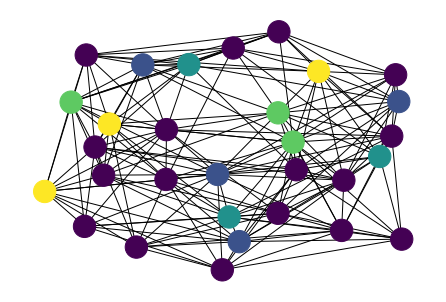

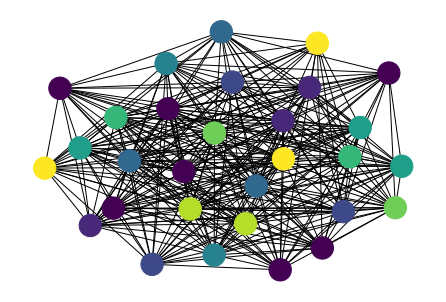

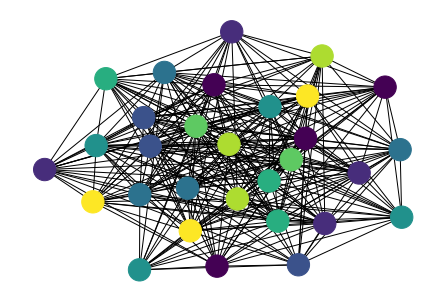

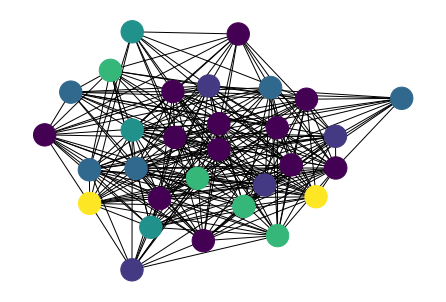

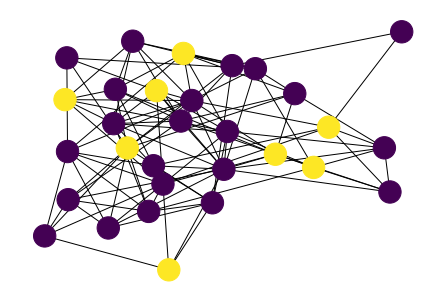

In [159]:
reshapert = x_synth_totaal.astype('float32')[[1110,2100,2331,2451,920], :] #39-50
# color_map = y_synth_totaal.astype('float32')[[1110,2100,2331,2451,920], :-1]

for i in range(5):
  first = nx.from_numpy_array(reshapert[i])
  # color_map = np.array(nx.greedy_color(first[1]))
  # color_map = np.array(list((nx.greedy_color(nx.from_numpy_array(reshapert[i])))))  
  color_map = varY3_test[i]
  nx.draw(first, node_size=500, alpha=1, node_color =color_map)
  plt.show()

In [124]:
len(color_map)

180

In [127]:
(reshapert[0]).shape

(30, 30)